# Gaussian process regression for CDR scores

This is a way to apply GPR to modeling CDR scores over age. It will take an iterative approach.

In [1]:
import warnings

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
import pymc as pm
import scipy
import seaborn as sns
import statsmodels.formula.api as smf
import xarray as xr

References:
- Page 468 of Statistical Rethinking
- [McElreath's lecture](https://www.youtube.com/watch?v=Y2ZLt4iOrXU) and [slides](https://raw.githubusercontent.com/rmcelreath/stat_rethinking_2023/main/slides/Lecture_16-gaussian_processes.pdf)
- pymc version 5 examples
    - from [kpjmcg](https://github.com/kpjmcg/Statistical-Rethinking-2023-Python-Notes/blob/master/Lecture_16_2023.ipynb)
    - from [dustinstansbury](https://github.com/dustinstansbury/statistical-rethinking-2023/blob/main/utils.py)

Analysis iteration:
- get working example for islands example
- working example for CDR simulation
- do nice animations like [gif](https://github.com/maxhumber/gif)


In [2]:
def draw_causal_graph(
    edge_list, node_props=None, edge_props=None, graph_direction="UD"
):
    """Utility to draw a causal (directed) graph
    From dustinstanbury
    """

    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g

def plot_kernel_function(
    kernel_function,
    max_distance=1,
    resolution=100,
    label=None,
    ax=None,
    **line_kwargs
):
    """Helper to plot a kernel function
    From dustinstanbury
    """
    def _plot_line(xs, ys, **plot_kwargs):
        """Plot line with consistent style (e.g. bordered lines)"""
        linewidth = plot_kwargs.get("linewidth", 3)
        plot_kwargs["linewidth"] = linewidth

        # Copy settings for background
        background_plot_kwargs = {k: v for k, v in plot_kwargs.items()}
        background_plot_kwargs["linewidth"] = linewidth + 2
        background_plot_kwargs["color"] = "white"
        del background_plot_kwargs["label"]  # no legend label for background

        plt.plot(xs, ys, **background_plot_kwargs, zorder=30)
        plt.plot(xs, ys, **plot_kwargs, zorder=31)


    X = np.linspace(0, max_distance, resolution)[:, None]
    covariance = kernel_function(X, X)
    distances = np.linspace(0, max_distance, resolution)
    if ax is not None:
        plt.sca(ax)
    _plot_line(distances, covariance[0, :], label=label, **line_kwargs)
    plt.xlim([0, max_distance])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("|X1-X2|")
    plt.ylabel("covariance")
    if label is not None:
        plt.legend()
    

# Kline example

In [3]:
# input data
DATA_DIR = '/Users/benlacar/Documents/career/data_science/repos/pymc-resources/Rethinking_2/End_of_chapter_problems/data/'
df_islands = pd.read_csv(os.path.join(DATA_DIR, 'islands.csv'), sep=";", header=0)
df_islands.head()

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0


The question of interest is to determine the association of population size with tools. But now account for spatial covariation: islands close together share unobserved confounds.

- P: population
- T: tools
- C: contact
- U: unobserved

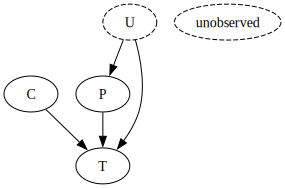

In [4]:
draw_causal_graph(
    edge_list=[
        ("P", "T"),
        ("C", "T"),
        ("U", "T"),
        ("U", "P")
    ],
    node_props={
        "U": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

## Start with an intercept only model
- ignore population to help explore spatial covariance


\begin{align*}
    T_i &\sim \text{Poisson}(\lambda_i) \\
    \lambda_i &= \bar \alpha + \alpha_{S[i]} \\
    \begin{pmatrix}
        \alpha_1 \\
        \alpha_2 \\
        \vdots \\
        \alpha_{10}
    \end{pmatrix} &= \text{MVNormal}
    \left( 
        \begin{bmatrix}
            0 \\
            0 \\
            \vdots \\
            0
        \end{bmatrix}, \textbf{K}
    \right)
\end{align*}

where
$ \bar{\alpha} $: The average toolkit complexity across all islands
<br>
$ \alpha_{S[i]} $: Each society S is some deviation from the average
<br>
$ \mathbf{K} $: This is where the magic happens. This models the covariance as a function of distance.

## The quadratic (L2) kernel function
- AKA RGB or Gaussian kernel
- There are other kernels available but I'm just focusing on this for now.

\begin{align*} K(x_i, x_j) = \eta^2 \exp \left(- \frac{(x_i - x_j)^2}{\sigma^2} \right) \end{align*}

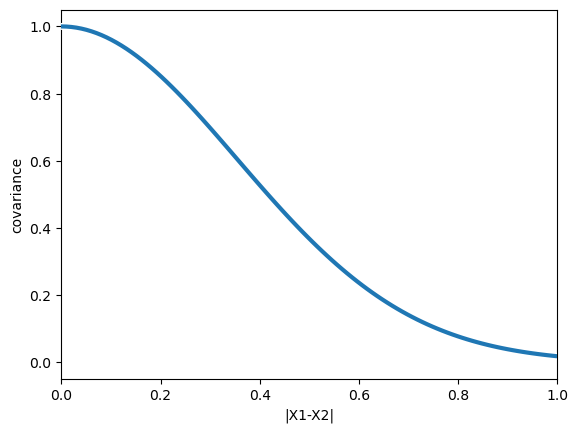

In [5]:
def quadratic_distance_kernel(X0, X1, eta=1, sigma=.5):
    # Use linear algebra identity: ||x-y||^2 = ||x||^2 + ||y||^2 - 2 * x^T * y
    X0_norm = np.sum(X0 ** 2, axis=-1)
    X1_norm = np.sum(X1 ** 2, axis=-1)
    squared_distances = X0_norm[:, None] + X1_norm[None, :] - 2 * X0 @ X1.T
    rho = 1 / sigma ** 2
    return eta ** 2 * np.exp(-rho * squared_distances)

plot_kernel_function(quadratic_distance_kernel)

## Distance-based model

\begin{align}
T_i &\sim \text{Poisson}(\lambda_i) \\
\log(\lambda_i) &= \bar \alpha + \alpha_{S[i]} \\
\begin{pmatrix}
\alpha_1 \\
\alpha_2 \\
\vdots \\
\alpha_{10}
\end{pmatrix} &= \text{MVNormal}\left( 
\begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix}, \textbf{K}
\right) \\
k_{i,j} &= \eta^2\exp(-\rho^2D_{i,j}^2)) \\
\bar{\alpha} &\sim \text{Normal}(3, 0.5) \\
\eta^2 &\sim \text{Exponential}(2) \\
\rho^2 &\sim \text{Exponential}(0.5)
\end{align}


In [9]:
islands_distance_matrix_file = 'https://raw.githubusercontent.com/dustinstansbury/statistical-rethinking-2023/main/data/islands_distance_matrix.csv'

Dmat = pd.read_csv(islands_distance_matrix_file, sep=";", header=0, index_col=None)
Dmat.index = Dmat.columns
Dmat.style.format(precision=2).background_gradient(cmap='viridis').set_caption("Distance in thousands of km")

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,0.00,0.47,0.63,4.36,1.23,2.04,3.18,2.79,1.86,5.68
Tikopia,0.47,0.00,0.32,4.17,1.24,2.01,2.88,2.67,1.97,5.28
Santa Cruz,0.63,0.32,0.00,3.86,1.55,1.71,2.59,2.36,2.28,5.40
Yap,4.36,4.17,3.86,0.00,5.39,2.46,1.55,1.62,6.14,7.18
Lau Fiji,1.23,1.24,1.55,5.39,0.00,3.22,4.03,3.91,0.76,4.88
Trobriand,2.04,2.01,1.71,2.46,3.22,0.00,1.80,0.85,3.89,6.65
Chuuk,3.18,2.88,2.59,1.55,4.03,1.80,0.00,1.21,4.79,5.79
Manus,2.79,2.67,2.36,1.62,3.91,0.85,1.21,0.00,4.62,6.72
Tonga,1.86,1.97,2.28,6.14,0.76,3.89,4.79,4.62,0.00,5.04
Hawaii,5.68,5.28,5.40,7.18,4.88,6.65,5.79,6.72,5.04,0.00


In [10]:
df_islands.head()

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0


In [22]:
culture_id, culture = pd.factorize(df_islands['culture'])
Dmat_island_distances = Dmat.values.astype(float)
coords = {"culture": culture}

with pm.Model(coords=coords) as distance_model:
        
    # Priors
    alpha_bar = pm.Normal("alpha_bar", 3, 0.5)
    eta_squared = pm.Exponential("eta_squared", 2)
    rho_squared = pm.Exponential("rho_squared", 0.5)
    
    # Gaussian Process
    kernel_function = eta_squared * pm.gp.cov.ExpQuad(input_dim=1, ls=rho_squared)
    GP = pm.gp.Latent(cov_func=kernel_function)
    alpha = GP.prior("alpha", X=Dmat_island_distances, dims="culture")
    
    # Likelihood
    lambda_T = pm.math.exp(alpha_bar + alpha[culture_id])
    pm.Poisson("T", lambda_T, dims='culture', observed=df_islands['total_tools'])

/Users/benlacar/opt/anaconda3/envs/pymc_env_2402/lib/python3.11/site-packages/pymc/gp/cov.py:190: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


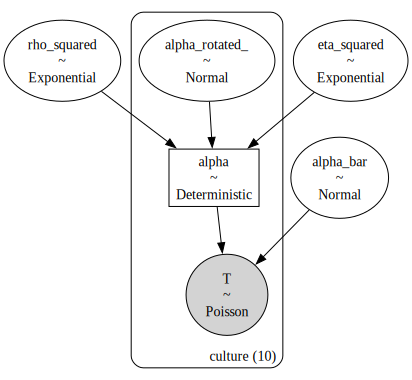

In [23]:
pm.model_to_graphviz(distance_model)

## Checking model with prior-predictive simulation

### Model the data

In [28]:
with distance_model:
    distance_inference = pm.sample(target_accept=.99)  # setting target_accept is needed to address rhat


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, eta_squared, rho_squared, alpha_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.


In [31]:
az.summary(distance_inference, var_names=["~alpha_rotated_"]) # Not sure what `alpha_rotated` is

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar,3.387,0.212,2.985,3.780,0.007,0.005,1032.0,1519.0,1.00
eta_squared,0.387,0.261,0.079,0.815,0.008,0.006,879.0,1628.0,1.01
rho_squared,0.252,0.527,0.000,0.628,0.034,0.024,445.0,200.0,1.01
alpha[Malekula],-0.676,0.297,-1.246,-0.139,0.007,0.005,1666.0,1443.0,1.00
alpha[Tikopia],-0.281,0.272,-0.802,0.216,0.007,0.005,1560.0,1767.0,1.00
alpha[Santa Cruz],-0.212,0.269,-0.699,0.314,0.007,0.005,1603.0,2099.0,1.00
alpha[Yap],0.344,0.250,-0.105,0.823,0.007,0.006,1228.0,1555.0,1.00
alpha[Lau Fiji],0.098,0.258,-0.395,0.567,0.007,0.005,1325.0,1895.0,1.00
alpha[Trobriand],-0.279,0.311,-0.833,0.328,0.012,0.008,788.0,658.0,1.00
alpha[Chuuk],0.265,0.246,-0.175,0.725,0.007,0.005,1404.0,1828.0,1.00


Note that the signs match but there's some disagreement with the R version.

You can plot the prior and posterior of the GPR parameters to show what's been learned.

# Simulated CDR data

- Make the data super simple.
- Idea is to show covariation for scores within certain ages.
- 3 subjects, aged between 60 and 70 with CDR scores

In [38]:
df_sim_cdr = pd.DataFrame(
    {
        'a':[0, 0.5, 0.5, 1, 1],
        'b':[0, 0, 0.5, 0, 0.5],
        'c':[0.5, 1, 1.5, 2, 3],
    },
    index=np.linspace(60, 70, 5)
)

df_sim_cdr

,a,b,c
60.0,0.0,0.0,0.5
62.5,0.5,0.0,1.0
65.0,0.5,0.5,1.5
67.5,1.0,0.0,2.0
70.0,1.0,0.5,3.0


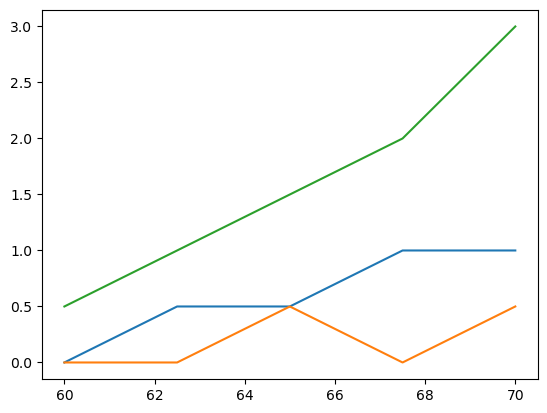

In [42]:
f, ax = plt.subplots()
ax.plot(df_sim_cdr)

Need to pool data across subjects and between timepoints.

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w


Last updated: Wed Feb 14 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

arviz      : 0.17.0
graphviz   : 0.20.1
pymc       : 5.10.3
numpy      : 1.25.2
xarray     : 2024.1.1
pandas     : 2.2.0
statsmodels: 0.14.1
scipy      : 1.12.0
matplotlib : 3.8.2
seaborn    : 0.13.2

Watermark: 2.4.3

